In [14]:
!pip install transformers
# !pip install tensorflow

In [15]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import Input, Dropout, Dense
import tensorflow as tf
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt

In [16]:
# Import data
df = pd.read_csv('app_reviews_all_annotated2.csv')
df = df[['review', 'argument_cat', 'decision_cat']]

# Remove missing rows
df = df.dropna()

df = df.groupby('argument_cat').filter(lambda x : len(x) > 1)
df = df.groupby('decision_cat').filter(lambda x : len(x) > 1)

# Convert to numeric for bert
df['Argument'] = pd.Categorical(df['argument_cat'])
df['Decision'] = pd.Categorical(df['decision_cat'])
df['argument_cat'] = df['Argument'].cat.codes
df['decision_cat'] = df['Decision'].cat.codes

# Split into training and testing 
df, df_test = train_test_split(df, test_size = 0.1, stratify=df[['argument_cat']])

In [17]:
# BERT model
modelName = 'bert-base-uncased'
maxLen = 100
conf = BertConfig.from_pretrained(modelName)
conf.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = modelName, config = conf)

# Load transformer BERT model
transformerModel = TFBertModel.from_pretrained(modelName, config = conf)

bert = transformerModel.layers[0]
inputIds = Input(shape=(maxLen,), name='input_ids', dtype='int32')
inputs = {'input_ids': inputIds}

bertModel = bert(inputs)[1]
dropout = Dropout(conf.hidden_dropout_prob, name='pooled_output')
pooledOutput = dropout(bertModel, training=False)

arg = Dense(units=len(df.argument_cat.value_counts()), kernel_initializer=TruncatedNormal(stddev=conf.initializer_range), name='argument')(pooledOutput)
dec = Dense(units=len(df.decision_cat.value_counts()), kernel_initializer=TruncatedNormal(stddev=conf.initializer_range), name='decision')(pooledOutput)
outputs = {'argument': arg, 'decision': dec}

# Show model
model = Model(inputs=inputs, outputs=outputs, name='BERT_For_App_Review_Classification')
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_For_App_Review_Classification"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           bert[0][1]                       
__________________________________________________________________________________________________
argument (Dense)                (None, 4)            3076        pooled_output[0][0]              
_________________________________________________________________

In [32]:
# Training
optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
loss = {'argument': CategoricalCrossentropy(from_logits = True), 'decision': CategoricalCrossentropy(from_logits = True)}
metric = {'argument': CategoricalAccuracy('accuracy'), 'decision': CategoricalAccuracy('accuracy')}
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

x = tokenizer(text=df.review.to_list(), add_special_tokens=True, max_length=maxLen, 
              truncation=True, padding=True, return_tensors='tf', return_token_type_ids = False,
              return_attention_mask = True, verbose = True)

history = model.fit(x={'input_ids': x['input_ids']}, y={'argument': to_categorical(df.argument_cat), 'decision': to_categorical(df.decision_cat)},
                    validation_split=0.1, batch_size=64, epochs=15)

Epoch 1/15
35/35 [==============================] - 65s 1s/step - loss: 0.0517 - argument_loss: 0.0388 - decision_loss: 0.0129 - argument_accuracy: 0.9875 - decision_accuracy: 0.9960 - val_loss: 1.0252 - val_argument_loss: 0.4674 - val_decision_loss: 0.5579 - val_argument_accuracy: 0.9076 - val_decision_accuracy: 0.8996
Epoch 2/15
35/35 [==============================] - 44s 1s/step - loss: 0.0397 - argument_loss: 0.0230 - decision_loss: 0.0166 - argument_accuracy: 0.9920 - decision_accuracy: 0.9951 - val_loss: 1.1741 - val_argument_loss: 0.5376 - val_decision_loss: 0.6365 - val_argument_accuracy: 0.8876 - val_decision_accuracy: 0.8916
Epoch 3/15
35/35 [==============================] - 44s 1s/step - loss: 0.0269 - argument_loss: 0.0163 - decision_loss: 0.0106 - argument_accuracy: 0.9960 - decision_accuracy: 0.9978 - val_loss: 1.1337 - val_argument_loss: 0.5111 - val_decision_loss: 0.6226 - val_argument_accuracy: 0.9116 - val_decision_accuracy: 0.9036
Epoch 4/15
35/35 [================

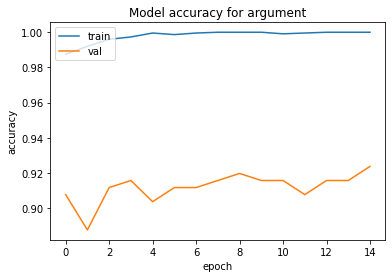

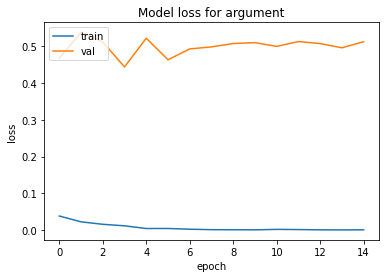

In [33]:
plt.plot(history.history['argument_accuracy'])
plt.plot(history.history['val_argument_accuracy'])
plt.title('Model accuracy for argument')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("\n")
plt.plot(history.history['argument_loss'])
plt.plot(history.history['val_argument_loss'])
plt.title('Model loss for argument')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

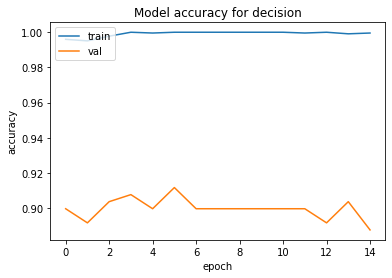

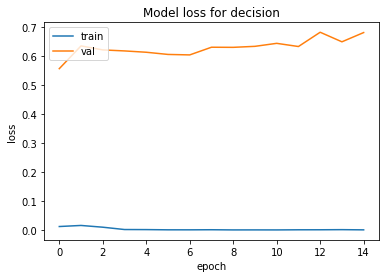

In [34]:
plt.plot(history.history['decision_accuracy'])
plt.plot(history.history['val_decision_accuracy'])
plt.title('Model accuracy for decision')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("\n")
plt.plot(history.history['decision_loss'])
plt.plot(history.history['val_decision_loss'])
plt.title('Model loss for decision')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
# Evaluation
testArg = to_categorical(df_test['argument_cat'], 4)
testDec = to_categorical(df_test['decision_cat'])
testReview = tokenizer(text=df_test['review'].to_list(), add_special_tokens=True,
                         max_length=maxLen, truncation=True, padding=True, 
                         return_tensors='tf', return_token_type_ids = False,
                         return_attention_mask = False, verbose = True)
modelEval = model.evaluate(x={'input_ids': testReview['input_ids']},
                                 y={'argument': testArg, 'decision': testDec})
modelPred = model.predict({'input_ids': testReview['input_ids']})

9/9 [==============================] - 2s 203ms/step - loss: 1.4354 - argument_loss: 0.7373 - decision_loss: 0.6981 - argument_accuracy: 0.8917 - decision_accuracy: 0.8917


In [38]:
print('For argument category:')
argumentPred =  tf.argmax(modelPred['argument'], axis=1).numpy()
y_pred = np.around(argumentPred)
print(metrics.classification_report(df_test.argument_cat, y_pred))

For argument category:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.91      0.97      0.94       234
           2       0.74      0.48      0.58        42

    accuracy                           0.89       277
   macro avg       0.55      0.48      0.51       277
weighted avg       0.88      0.89      0.88       277



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
print('For decision category:')
decisionPred =  tf.argmax(modelPred['decision'], axis=1).numpy()
y_pred = np.around(decisionPred)
print(metrics.classification_report(df_test.decision_cat, y_pred))

For decision category:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       125
           1       0.86      0.60      0.71        10
           2       0.94      0.94      0.94        34
           3       0.91      0.96      0.94        76
           4       0.81      0.69      0.75        32

    accuracy                           0.89       277
   macro avg       0.88      0.82      0.85       277
weighted avg       0.89      0.89      0.89       277

